# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import time
import cv2
import random
from shutil import copyfile
import json
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import torchvision
import torchvision.transforms as T
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
SQUEEZENET_MEAN = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float)
SQUEEZENET_STD = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float)
from PIL import Image
from tqdm import tqdm


<ipython-input-2-3243137eca54>:18: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [ ]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = 'cpu'

Using the GPU. You are good to go!


Loading the data. Essentially, unzips the kaggle data into pngs to input into the CNN. They are 424x424 Jpegs for GZ2.

# Make Subset

In [ ]:
import os
import shutil

# Set the path to the folder containing the images
source_folder = '/content/drive/MyDrive/442_Galaxies_Project/Data/images_training_rev1'

# Set the path to the folder where the images will be copied
dest_folder = '/content/drive/MyDrive/442_Galaxies_Project/Data/subset'

# Set the maximum number of images to copy
max_images = 5000

# Create the destination folder if it doesn't exist
if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)
    exit()
if not os.path.exists(source_folder):
    exit()

# Loop through the files in the source folder and copy the first 5000 images to the destination folder
count = 0
# print (len(os.listdir(source_folder)))
# for filename in os.listdir(source_folder):
#     if count < max_images:
#         src_path = os.path.join(source_folder, filename)
#         dest_path = os.path.join(dest_folder, filename)
#         shutil.copy(src_path, dest_path)
#         count += 1
#         if count % 250 == 0:
#           print(count)
#     else:
#         break

print(f'{count} images copied to {dest_folder}')


250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5000 images copied to /content/drive/MyDrive/442_Galaxies_Project/Data/subset


# Pre-Processing

In [ ]:
# Set the paths for input and output folders
input_folder = '/content/drive/MyDrive/442_Galaxies_Project/Data/subset'
output_folder = '/content/drive/MyDrive/442_Galaxies_Project/Data/preprocessed'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through each file in input folder
for filename in os.listdir(input_folder):
    # Check if file is an image
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Load the image
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)

        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Resize image
        im_resized = gray_image[83:339, 83:339]

        # Save grayscale image to output folder
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, im_resized)

# Splitting

In [ ]:
# Dataset path
dataset_path = "/content/drive/MyDrive/442_Galaxies_Project/Data/preprocessed"

# Splitting Ratios (TO TUNE)
train_split_ratio = 0.7
val_split_ratio = 0.15
test_split_ratio = 0.15

# Create directories for training, validation, and testing sets
train_path = os.path.join(dataset_path, "train_img")
val_path = os.path.join(dataset_path, "val_img")
test_path = os.path.join(dataset_path, "test_img")
if not os.path.exists(train_path):
    os.makedirs(train_path)
if not os.path.exists(val_path):
    os.makedirs(val_path)
if not os.path.exists(test_path):
    os.makedirs(test_path)

# Get list of image filenames
image_files = [filename for filename in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, filename)) and (filename.endswith(".jpeg") or filename.endswith(".jpg"))]

# Shuffle the list of image filenames
random.shuffle(image_files)

# Calculate number of images for each split
num_images = len(image_files)
num_train = int(num_images * train_split_ratio)
num_val = int(num_images * val_split_ratio)
num_test = num_images - num_train - num_val

# Loop through shuffled image filenames and copy them to the respective split sets
count = 0
for i, filename in enumerate(image_files):
    file_path = os.path.join(dataset_path, filename)
    if i < num_train:
        dest_folder = train_path
    elif i < num_train + num_val:
        dest_folder = val_path
    else:
        dest_folder = test_path
    dest_path = os.path.join(dest_folder, filename)
    copyfile(file_path, dest_path)
    if count % 250 == 0:
          print(count)
    count += 1


0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750


# Creating Labels

In [ ]:
# TODO (creating python dict of labeles for each image)
import csv

# Open the CSV file
with open('/content/drive/MyDrive/442_Galaxies_Project/Data/training_solutions_rev1.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)

    # Skip the header row
    next(reader)

    # Create an empty dictionary to store the vectors
    data_dict = {}

    # Iterate over the rows in the CSV file
    for row in reader:

        # Get the key (value in column A) and the vector (values from columns B to AL)
        key = row[0]
        vector = [float(val) for val in row[1:]]

        # Add the vector to the dictionary
        data_dict[key] = torch.tensor(vector)

print(data_dict["100134"])


tensor([0.0218, 0.9770, 0.0012, 0.0218, 0.9552, 0.3131, 0.6421, 0.5465, 0.4087,
        0.1601, 0.7607, 0.0344, 0.0000, 0.6115, 0.3885, 0.0109, 0.0109, 0.0000,
        0.0000, 0.0324, 0.0641, 0.4502, 0.0000, 0.0324, 0.0324, 0.0000, 0.0000,
        0.0218, 0.2073, 0.1520, 0.1872, 0.0000, 0.0000, 0.0546, 0.0820, 0.0820,
        0.3279])


# DataLoader

In [ ]:
class PNGDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.images = os.listdir(root_dir)
        self.transform = transform
        self.labels = []
        for i in range(len(self.images)):
          image_name = self.images[i]
          image_num = image_name.split(".")[0]
          self.labels.append(data_dict[image_num])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_name = self.images[index]
        image_path = os.path.join(self.root_dir, image_name)
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        image_num = image_name.split(".")[0]
        return image, self.labels[index]

transformTrain = T.Compose([transforms.ToTensor()])
datasetTrain = PNGDataset('/content/drive/MyDrive/442_Galaxies_Project/Data/preprocessed/train_img', transform=transformTrain)
print("train ", datasetTrain.__len__())
transformVal = T.Compose([transforms.ToTensor()])
datasetVal = PNGDataset('/content/drive/MyDrive/442_Galaxies_Project/Data/preprocessed/val_img', transform=transformVal)
print("val ", datasetVal.__len__())
transformTest = T.Compose([transforms.ToTensor()])
datasetTest = PNGDataset('/content/drive/MyDrive/442_Galaxies_Project/Data/preprocessed/test_img', transform=transformVal)
print("test ", datasetTest.__len__())
#print(datasetTrain.len)
# # create an instance of your custom dataset
# dataset = PNGDataset('/content/drive/MyDrive/442 Galaxies Project/Data/testingDataLoader')

# create a data loader for your dataset
batch_size = 35
dataloaderTrain = DataLoader(datasetTrain, batch_size=batch_size, shuffle=True)

batch_size = 10
dataloaderVal = DataLoader(datasetVal, batch_size=batch_size, shuffle=True)

batch_size = 10
dataloaderTest = DataLoader(datasetTest, batch_size=batch_size, shuffle=True)


# iterate over the data loader to get batches of data
i = 1
# for something in dataloaderTrain:
#     print("i", i)
#     print("len", len(something))
#     print(something[0].shape)
#     print(something[1].shape)
#     i = i+1
# for label in dataloaderLabels:
#   print(label)

train  3500
val  750
test  750


# CNN

NN implementation.

Key details for impl: 424x424 input. 37 output "class labels" (wrapper to be written later)

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d(kernel_size=(4,4))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(5, 5))
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=16, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))
        self.drop1 = nn.Dropout(.25)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3))
        self.drop2 = nn.Dropout(.5)
        self.fc1 = nn.Linear(5408, 37) # will change depending on the number of classes

    # def init_weights(self):
    #     """Initialize all model parameters (weights and biases) in all layers to desired distributions"""

    #     for conv in [self.conv1, self.conv2, self.conv3]:
    #         C_in = conv.weight.size(1)
    #         nn.init.normal_(conv.weight, 0.0, 1 / np.sqrt(2 * 2 * C_in))
    #         nn.init.constant_(conv.bias, 0.0)

    #     ## TODO: initialize the parameters for [self.fc1]
    #     inputs = self.fc1.weight.size(1)
    #     nn.init.normal_(self.fc1.weight, 0.0, np.sqrt(1 / inputs))
    #     nn.init.constant_(self.fc1.bias, 0.0)


    def forward(self, x):
        """This function defines the forward propagation for a batch of input examples, by
            successively passing output of the previous layer as the input into the next layer (after applying
            activation functions), and returning the final output as a torch.Tensor object

            You may optionally use the x.shape variables below to resize/view the size of
            the input matrix at different points of the forward pass"""
        N, C, H, W = x.shape

        ## TODO: forward pass
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = self.drop1(x)
        x = F.relu(self.conv4(x))
        x = self.drop2(x)
        x = torch.flatten(x, 1)
        z = self.fc1(x)
        ##

        return z


model = Network().to(device)
criterion = nn.CrossEntropyLoss() # Specify the loss layer
print('Your network:')
print(summary(model, (1,256,256), device=device)) # visualize your model

# Set up optimization hyperparameters
learning_rate = 1e-1 # TODO: Choose an appropriate number for learning_rate
weight_decay = 0 # TODO: Choose an appropriate number for weight decay
num_epoch = 50  # TODO: Choose an appropriate number of training epochs
optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                       weight_decay=weight_decay) # Try different optimizers potentially

Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 254, 254]             640
         MaxPool2d-2           [-1, 64, 63, 63]               0
            Conv2d-3          [-1, 256, 59, 59]         409,856
            Conv2d-4           [-1, 16, 57, 57]          36,880
         MaxPool2d-5           [-1, 16, 28, 28]               0
           Dropout-6           [-1, 16, 28, 28]               0
            Conv2d-7            [-1, 8, 26, 26]           1,160
           Dropout-8            [-1, 8, 26, 26]               0
            Linear-9                   [-1, 37]         200,133
Total params: 648,669
Trainable params: 648,669
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 40.91
Params size (MB): 2.47
Estimated Total Size (MB): 43.63
---------------------------

Training:

Start training...
-----------------Epoch = 1-----------------


100%|██████████| 100/100 [47:29<00:00, 28.49s/it]



 Epoch 1 loss:704.2005683135986


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]



 Evaluation accuracy: 0.45885714285714285

 Evaluate on validation set...


100%|██████████| 75/75 [10:04<00:00,  8.06s/it]



 Evaluation accuracy: 0.4826666666666667
-----------------Epoch = 2-----------------


100%|██████████| 100/100 [00:11<00:00,  8.54it/s]



 Epoch 2 loss:15.402738199234008


100%|██████████| 100/100 [00:11<00:00,  8.51it/s]



 Evaluation accuracy: 0.4697142857142857

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 29.05it/s]



 Evaluation accuracy: 0.49733333333333335
-----------------Epoch = 3-----------------


100%|██████████| 100/100 [00:11<00:00,  8.50it/s]



 Epoch 3 loss:15.405088682174682


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]



 Evaluation accuracy: 0.474

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 26.62it/s]



 Evaluation accuracy: 0.49866666666666665
-----------------Epoch = 4-----------------


100%|██████████| 100/100 [00:11<00:00,  8.66it/s]



 Epoch 4 loss:15.409399089813233


100%|██████████| 100/100 [00:11<00:00,  8.67it/s]



 Evaluation accuracy: 0.45085714285714285

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 26.68it/s]



 Evaluation accuracy: 0.48133333333333334
-----------------Epoch = 5-----------------


100%|██████████| 100/100 [00:11<00:00,  8.69it/s]



 Epoch 5 loss:15.411270561218261


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]



 Evaluation accuracy: 0.4634285714285714

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 28.06it/s]



 Evaluation accuracy: 0.492
-----------------Epoch = 6-----------------


100%|██████████| 100/100 [00:11<00:00,  8.63it/s]



 Epoch 6 loss:15.407050352096558


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]



 Evaluation accuracy: 0.4522857142857143

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 31.19it/s]



 Evaluation accuracy: 0.4746666666666667
-----------------Epoch = 7-----------------


100%|██████████| 100/100 [00:11<00:00,  8.53it/s]



 Epoch 7 loss:15.41009874343872


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]



 Evaluation accuracy: 0.45771428571428574

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 30.21it/s]



 Evaluation accuracy: 0.4786666666666667
-----------------Epoch = 8-----------------


100%|██████████| 100/100 [00:11<00:00,  8.57it/s]



 Epoch 8 loss:15.409969959259033


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]



 Evaluation accuracy: 0.4637142857142857

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 30.12it/s]



 Evaluation accuracy: 0.48133333333333334
-----------------Epoch = 9-----------------


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]



 Epoch 9 loss:15.410412664413451


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]



 Evaluation accuracy: 0.4694285714285714

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 30.48it/s]



 Evaluation accuracy: 0.5066666666666667
-----------------Epoch = 10-----------------


100%|██████████| 100/100 [00:11<00:00,  8.53it/s]



 Epoch 10 loss:15.408572473526


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]



 Evaluation accuracy: 0.468

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 29.66it/s]



 Evaluation accuracy: 0.4866666666666667
-----------------Epoch = 11-----------------


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]



 Epoch 11 loss:15.406220750808716


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]



 Evaluation accuracy: 0.45771428571428574

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 30.81it/s]



 Evaluation accuracy: 0.4866666666666667
-----------------Epoch = 12-----------------


100%|██████████| 100/100 [00:11<00:00,  8.54it/s]



 Epoch 12 loss:15.408112649917603


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]



 Evaluation accuracy: 0.4762857142857143

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 29.24it/s]



 Evaluation accuracy: 0.5013333333333333
-----------------Epoch = 13-----------------


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]



 Epoch 13 loss:15.408528604507445


100%|██████████| 100/100 [00:11<00:00,  8.51it/s]



 Evaluation accuracy: 0.48228571428571426

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 27.13it/s]



 Evaluation accuracy: 0.5093333333333333
-----------------Epoch = 14-----------------


100%|██████████| 100/100 [00:11<00:00,  8.58it/s]



 Epoch 14 loss:15.40913507461548


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]



 Evaluation accuracy: 0.45371428571428574

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 26.37it/s]



 Evaluation accuracy: 0.4746666666666667
-----------------Epoch = 15-----------------


100%|██████████| 100/100 [00:11<00:00,  8.63it/s]



 Epoch 15 loss:15.407751960754394


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]



 Evaluation accuracy: 0.47714285714285715

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 27.52it/s]



 Evaluation accuracy: 0.49733333333333335
-----------------Epoch = 16-----------------


100%|██████████| 100/100 [00:11<00:00,  8.64it/s]



 Epoch 16 loss:15.410081205368042


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]



 Evaluation accuracy: 0.4774285714285714

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 30.50it/s]



 Evaluation accuracy: 0.49866666666666665
-----------------Epoch = 17-----------------


100%|██████████| 100/100 [00:11<00:00,  8.50it/s]



 Epoch 17 loss:15.410479364395142


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]



 Evaluation accuracy: 0.446

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 30.20it/s]



 Evaluation accuracy: 0.4706666666666667
-----------------Epoch = 18-----------------


100%|██████████| 100/100 [00:11<00:00,  8.56it/s]



 Epoch 18 loss:15.412351760864258


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]



 Evaluation accuracy: 0.456

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 31.15it/s]



 Evaluation accuracy: 0.4786666666666667
-----------------Epoch = 19-----------------


100%|██████████| 100/100 [00:11<00:00,  8.58it/s]



 Epoch 19 loss:15.410201177597045


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]



 Evaluation accuracy: 0.4662857142857143

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 31.02it/s]



 Evaluation accuracy: 0.48933333333333334
-----------------Epoch = 20-----------------


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]



 Epoch 20 loss:15.406814489364624


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]



 Evaluation accuracy: 0.4642857142857143

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 30.44it/s]



 Evaluation accuracy: 0.49066666666666664
-----------------Epoch = 21-----------------


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]



 Epoch 21 loss:15.412482919692993


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]



 Evaluation accuracy: 0.47314285714285714

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 31.74it/s]



 Evaluation accuracy: 0.49466666666666664
-----------------Epoch = 22-----------------


100%|██████████| 100/100 [00:11<00:00,  8.56it/s]



 Epoch 22 loss:15.410643396377564


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]



 Evaluation accuracy: 0.45285714285714285

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 30.63it/s]



 Evaluation accuracy: 0.4786666666666667
-----------------Epoch = 23-----------------


100%|██████████| 100/100 [00:11<00:00,  8.62it/s]



 Epoch 23 loss:15.41525902748108


100%|██████████| 100/100 [00:11<00:00,  8.67it/s]



 Evaluation accuracy: 0.4637142857142857

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 28.49it/s]



 Evaluation accuracy: 0.5013333333333333
-----------------Epoch = 24-----------------


100%|██████████| 100/100 [00:11<00:00,  8.77it/s]



 Epoch 24 loss:15.412941932678223


100%|██████████| 100/100 [00:11<00:00,  8.65it/s]



 Evaluation accuracy: 0.45914285714285713

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 25.95it/s]



 Evaluation accuracy: 0.49066666666666664
-----------------Epoch = 25-----------------


100%|██████████| 100/100 [00:11<00:00,  8.73it/s]



 Epoch 25 loss:15.412677602767944


100%|██████████| 100/100 [00:11<00:00,  8.51it/s]



 Evaluation accuracy: 0.4817142857142857

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 29.61it/s]



 Evaluation accuracy: 0.5066666666666667
-----------------Epoch = 26-----------------


100%|██████████| 100/100 [00:11<00:00,  8.56it/s]



 Epoch 26 loss:15.412254590988159


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]



 Evaluation accuracy: 0.4551428571428571

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 30.88it/s]



 Evaluation accuracy: 0.4786666666666667
-----------------Epoch = 27-----------------


100%|██████████| 100/100 [00:11<00:00,  8.49it/s]



 Epoch 27 loss:15.411378831863404


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]



 Evaluation accuracy: 0.45257142857142857

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 30.86it/s]



 Evaluation accuracy: 0.4786666666666667
-----------------Epoch = 28-----------------


100%|██████████| 100/100 [00:11<00:00,  8.59it/s]



 Epoch 28 loss:15.407561464309692


100%|██████████| 100/100 [00:11<00:00,  8.57it/s]



 Evaluation accuracy: 0.45914285714285713

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 31.21it/s]



 Evaluation accuracy: 0.49066666666666664
-----------------Epoch = 29-----------------


100%|██████████| 100/100 [00:11<00:00,  8.64it/s]



 Epoch 29 loss:15.409203882217406


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]



 Evaluation accuracy: 0.4665714285714286

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 30.74it/s]



 Evaluation accuracy: 0.492
-----------------Epoch = 30-----------------


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]



 Epoch 30 loss:15.408747034072876


100%|██████████| 100/100 [00:11<00:00,  8.56it/s]



 Evaluation accuracy: 0.4654285714285714

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 31.79it/s]



 Evaluation accuracy: 0.49333333333333335
-----------------Epoch = 31-----------------


100%|██████████| 100/100 [00:11<00:00,  8.63it/s]



 Epoch 31 loss:15.411812181472778


100%|██████████| 100/100 [00:11<00:00,  8.58it/s]



 Evaluation accuracy: 0.4762857142857143

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 30.40it/s]



 Evaluation accuracy: 0.5053333333333333
-----------------Epoch = 32-----------------


100%|██████████| 100/100 [00:11<00:00,  8.62it/s]



 Epoch 32 loss:15.41113013267517


100%|██████████| 100/100 [00:11<00:00,  8.71it/s]



 Evaluation accuracy: 0.456

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 27.06it/s]



 Evaluation accuracy: 0.4826666666666667
-----------------Epoch = 33-----------------


100%|██████████| 100/100 [00:11<00:00,  8.62it/s]



 Epoch 33 loss:15.410357103347778


100%|██████████| 100/100 [00:11<00:00,  8.60it/s]



 Evaluation accuracy: 0.4617142857142857

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 27.67it/s]



 Evaluation accuracy: 0.5013333333333333
-----------------Epoch = 34-----------------


100%|██████████| 100/100 [00:11<00:00,  8.80it/s]



 Epoch 34 loss:15.4095299243927


100%|██████████| 100/100 [00:11<00:00,  8.51it/s]



 Evaluation accuracy: 0.4734285714285714

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 30.13it/s]



 Evaluation accuracy: 0.49466666666666664
-----------------Epoch = 35-----------------


100%|██████████| 100/100 [00:11<00:00,  8.70it/s]



 Epoch 35 loss:15.409183340072632


100%|██████████| 100/100 [00:11<00:00,  8.58it/s]



 Evaluation accuracy: 0.4551428571428571

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 30.97it/s]



 Evaluation accuracy: 0.48133333333333334
-----------------Epoch = 36-----------------


100%|██████████| 100/100 [00:11<00:00,  8.59it/s]



 Epoch 36 loss:15.413492860794067


100%|██████████| 100/100 [00:11<00:00,  8.50it/s]



 Evaluation accuracy: 0.46685714285714286

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 31.79it/s]



 Evaluation accuracy: 0.488
-----------------Epoch = 37-----------------


100%|██████████| 100/100 [00:11<00:00,  8.66it/s]



 Epoch 37 loss:15.411752977371215


100%|██████████| 100/100 [00:11<00:00,  8.49it/s]



 Evaluation accuracy: 0.45971428571428574

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 28.63it/s]



 Evaluation accuracy: 0.4826666666666667
-----------------Epoch = 38-----------------


100%|██████████| 100/100 [00:11<00:00,  8.50it/s]



 Epoch 38 loss:15.41151845932007


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]



 Evaluation accuracy: 0.48514285714285715

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 29.77it/s]



 Evaluation accuracy: 0.5146666666666667
-----------------Epoch = 39-----------------


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]



 Epoch 39 loss:15.409781694412231


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]



 Evaluation accuracy: 0.4554285714285714

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 29.37it/s]



 Evaluation accuracy: 0.484
-----------------Epoch = 40-----------------


100%|██████████| 100/100 [00:11<00:00,  8.53it/s]



 Epoch 40 loss:15.40868293762207


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]



 Evaluation accuracy: 0.44885714285714284

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 29.97it/s]



 Evaluation accuracy: 0.468
-----------------Epoch = 41-----------------


100%|██████████| 100/100 [00:11<00:00,  8.50it/s]



 Epoch 41 loss:15.40938006401062


100%|██████████| 100/100 [00:11<00:00,  8.60it/s]



 Evaluation accuracy: 0.472

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 27.25it/s]



 Evaluation accuracy: 0.49333333333333335
-----------------Epoch = 42-----------------


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]



 Epoch 42 loss:15.41672369003296


100%|██████████| 100/100 [00:11<00:00,  8.59it/s]



 Evaluation accuracy: 0.4602857142857143

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 26.98it/s]



 Evaluation accuracy: 0.4866666666666667
-----------------Epoch = 43-----------------


100%|██████████| 100/100 [00:11<00:00,  8.70it/s]



 Epoch 43 loss:15.414394445419312


100%|██████████| 100/100 [00:11<00:00,  8.51it/s]



 Evaluation accuracy: 0.47285714285714286

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 28.03it/s]



 Evaluation accuracy: 0.49733333333333335
-----------------Epoch = 44-----------------


100%|██████████| 100/100 [00:11<00:00,  8.69it/s]



 Epoch 44 loss:15.413053121566772


100%|██████████| 100/100 [00:11<00:00,  8.49it/s]



 Evaluation accuracy: 0.4717142857142857

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 30.60it/s]



 Evaluation accuracy: 0.48933333333333334
-----------------Epoch = 45-----------------


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]



 Epoch 45 loss:15.413931713104247


100%|██████████| 100/100 [00:11<00:00,  8.50it/s]



 Evaluation accuracy: 0.44971428571428573

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 31.03it/s]



 Evaluation accuracy: 0.4826666666666667
-----------------Epoch = 46-----------------


100%|██████████| 100/100 [00:11<00:00,  8.64it/s]



 Epoch 46 loss:15.414449577331544


100%|██████████| 100/100 [00:11<00:00,  8.59it/s]



 Evaluation accuracy: 0.43685714285714283

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 31.40it/s]



 Evaluation accuracy: 0.46266666666666667
-----------------Epoch = 47-----------------


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]



 Epoch 47 loss:15.415083980560302


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]



 Evaluation accuracy: 0.45285714285714285

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 31.46it/s]



 Evaluation accuracy: 0.476
-----------------Epoch = 48-----------------


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]



 Epoch 48 loss:15.407448205947876


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]



 Evaluation accuracy: 0.4594285714285714

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 30.83it/s]



 Evaluation accuracy: 0.4866666666666667
-----------------Epoch = 49-----------------


100%|██████████| 100/100 [00:11<00:00,  8.65it/s]



 Epoch 49 loss:15.409561176300048


100%|██████████| 100/100 [00:11<00:00,  8.51it/s]



 Evaluation accuracy: 0.45457142857142857

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 30.69it/s]



 Evaluation accuracy: 0.48133333333333334
-----------------Epoch = 50-----------------


100%|██████████| 100/100 [00:11<00:00,  8.50it/s]



 Epoch 50 loss:15.407841854095459


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]



 Evaluation accuracy: 0.46514285714285714

 Evaluate on validation set...


100%|██████████| 75/75 [00:02<00:00, 29.57it/s]



 Evaluation accuracy: 0.49066666666666664
Done!


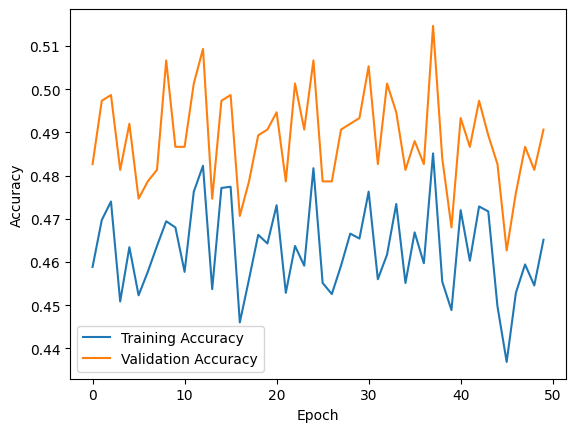


 Evaluate on test set


100%|██████████| 75/75 [10:13<00:00,  8.18s/it]


 Evaluation accuracy: 0.45866666666666667
CPU times: user 15min 1s, sys: 58.8 s, total: 16min
Wall time: 1h 29min 14s


0.45866666666666667

In [ ]:
# HW version
%%time
import sys
def train(model, dataloaderTrain, dataloaderVal, num_epoch=10, max_seconds=None):  # Train the model

    print("Start training...")
    trn_loss_hist = []
    trn_acc_hist = []
    val_acc_hist = []
    model.train()  # Set the model to training mode
    str_time = time.time()
    for i in range(num_epoch):
        running_loss = []
        print('-----------------Epoch = %d-----------------' % (i+1))
        for batch, label in tqdm(dataloaderTrain):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad()  # Clear gradients from the previous iteration
            # This will call Network.forward() that you implement
            pred = model(batch)
            loss = criterion(pred, label)  # Calculate the loss
            running_loss.append(loss.item())
            loss.backward()  # Backprop gradients to all tensors in the network
            optimizer.step()  # Update trainable weights

        print("\n Epoch {} loss:{}".format(i+1, np.mean(running_loss)))

        # Keep track of training loss, accuracy, and validation loss
        trn_loss_hist.append(np.mean(running_loss))
        trn_acc_hist.append(evaluate(model, dataloaderTrain))

        print("\n Evaluate on validation set...")
        val_acc_hist.append(evaluate(model, dataloaderVal))

        # Check if max_seconds is reached
        # if max_seconds and time.time() - str_time >= max_seconds:
        #     print("Max time limit reached. Stopping training.")
        #     return trn_loss_hist, trn_acc_hist, val_acc_hist

    print("Done!")
    return trn_loss_hist, trn_acc_hist, val_acc_hist


def evaluate(model, loader):  # Evaluate accuracy on validation / test set

    model.eval()  # Set the model to evaluation mode
    correct = 0
    with torch.no_grad():  # Do not calculate grident to speed up computation
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device).cpu().numpy()
            pred = model(batch)
            pred = pred.to(device).cpu().numpy()


            label_sum = np.reshape(np.sum(label, axis = 1), (-1, 1))
            # print(label_sum)
            pred_sum = np.sum(np.abs(pred), axis = 1)
            pred_sum = np.reshape(pred_sum, (-1, 1))
            # print(pred_sum.shape)
            norm_factor = 1/pred_sum
            # print(norm_factor.shape)
            norm_pred = np.abs(pred * norm_factor)
            # print(norm_pred)
            norm_label = label/label_sum
            #diff = np.abs(pred - label)
            diff = np.abs(norm_pred - norm_label)
            # print(diff)
            corrmatr = (diff < 0.1)
            corrsum = np.sum(corrmatr, axis = 1)
            # print(corrsum)
            correct += np.sum((corrsum >= 35))
        acc = correct/len(loader.dataset)

        print("\n Evaluation accuracy: {}".format(acc))
        return acc


trn_loss_hist, trn_acc_hist, val_acc_hist = train(model, dataloaderTrain,
                                                  dataloaderVal, num_epoch,
                                                  36000)


import matplotlib.pyplot as plt

# Plot training and validation accuracy on the same plot
plt.plot(trn_acc_hist, label='Training Accuracy')
plt.plot(val_acc_hist, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


##############################################################################
# TODO: Note down the evaluation accuracy on test set                        #
##############################################################################
print("\n Evaluate on test set")
evaluate(model, dataloaderTest)